# Simulation 3D of a position controller for a DC motor using PID linear fuzzy controller

***by Dr. Martin Montes Rivera***

Once installed all the required libraries also install blockdiag to update the block diagram.

For starting the movement of the motor press "q" when appears the simulation window

## REQUIRED IMPORTANT LIBRARIES FOR THE SIMULATION

In [14]:
import control
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, SVG, display, clear_output
import time
from ipyvtk_simple.viewer import ViewInteractiveWidget
from pytictoc import TicToc
from vedo import *
from UPAFuzzySystems import fuzzy_universe, inference_system, fuzzy_controller
t = TicToc() 

## Important Functions

In [15]:
def send_dataBlock(datablock):
    f= open("block_diagram","w+")
    f.write('blockdiag { '+datablock+' }')
    f.close() 
    os.system("blockdiag block_diagram -Tsvg")
    

In [16]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [17]:
def step_info(yout_val,t,settt=0.01):
    yout = moving_average(yout_val,15)
    maxval = np.amax(yout)
    minval = np.amin(yout)
    timerising = 0
    settlingtime = 0
    start_val = yout[0]
    end_val = yout[-1]
    overshoot = (maxval/yout[-1]-1)*100
    a = 0
    for i in range(len(yout)):
        if yout[i]==maxval:
            time_overshoot = t[i]
        if yout[i]>(yout[-1]*.90) and a==0 :
            timerising = t[i]
            a = 1
        if abs((yout[i]-yout[-1])/yout[-1])>=settt:
            settlingtime = t[i]
    if overshoot == 0:
        time_overshoot = 'N/A'
    step_infor_obt = [maxval,minval,start_val,end_val,timerising,overshoot,time_overshoot,settlingtime]
    print("Step Info Obtained:", "\nmaxval: ",step_infor_obt[0],"\nminval: ",step_infor_obt[1],"\nstart_val: ",step_infor_obt[2],"\nend_val: ",step_infor_obt[3],"\ntimerising: ",step_infor_obt[4],"\novershoot: ",step_infor_obt[5],"\ntime overshoot: ",step_infor_obt[6],"\nsettlingtime: ",step_infor_obt[7])
    return

## Defining the system

In [18]:
J = 3.2284E-6;
b = 3.5077E-6;
K = 0.0274;
R = 4;
L = 2.75E-6;
te = 1.0
ns = 1500

T=np.linspace(0,te,ns)
s = control.TransferFunction.s 
TF = K/(s*((J*s+b)*(L*s+R)+K**2))


## Defining the input of the system

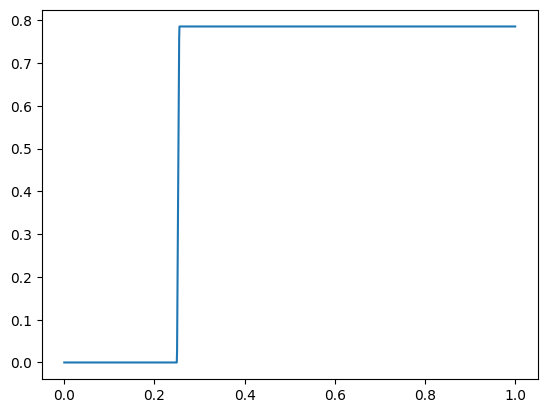

In [19]:

Input = np.array([(np.radians(45)*min((t-0.25)/0.005,1)) if t> 0.25 else 0 for t in T])
plt.plot(T,Input)


## Defining the System Rules

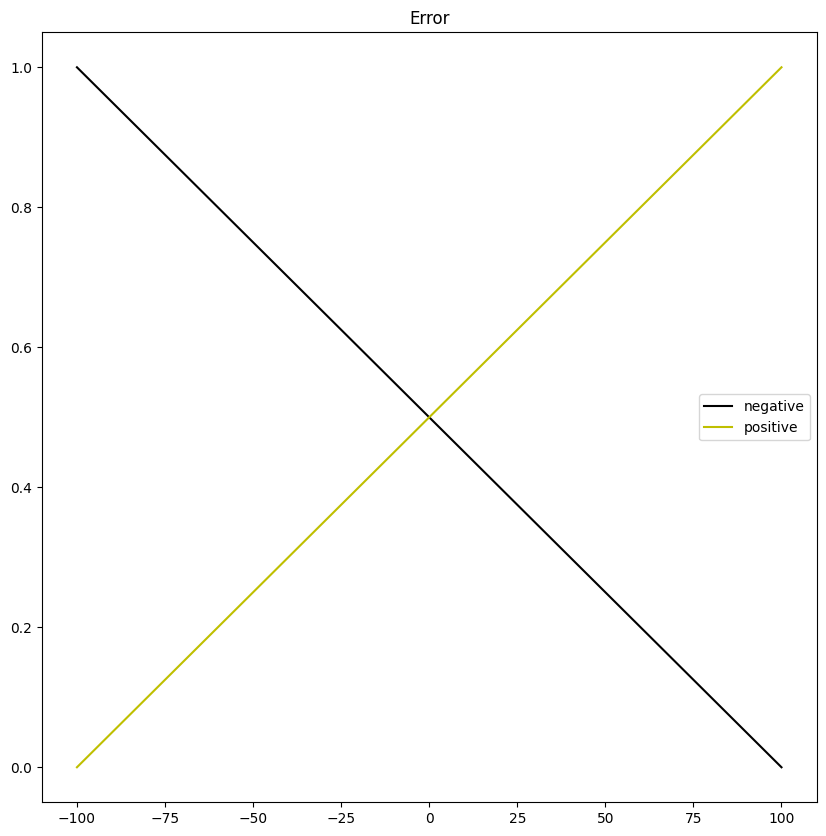

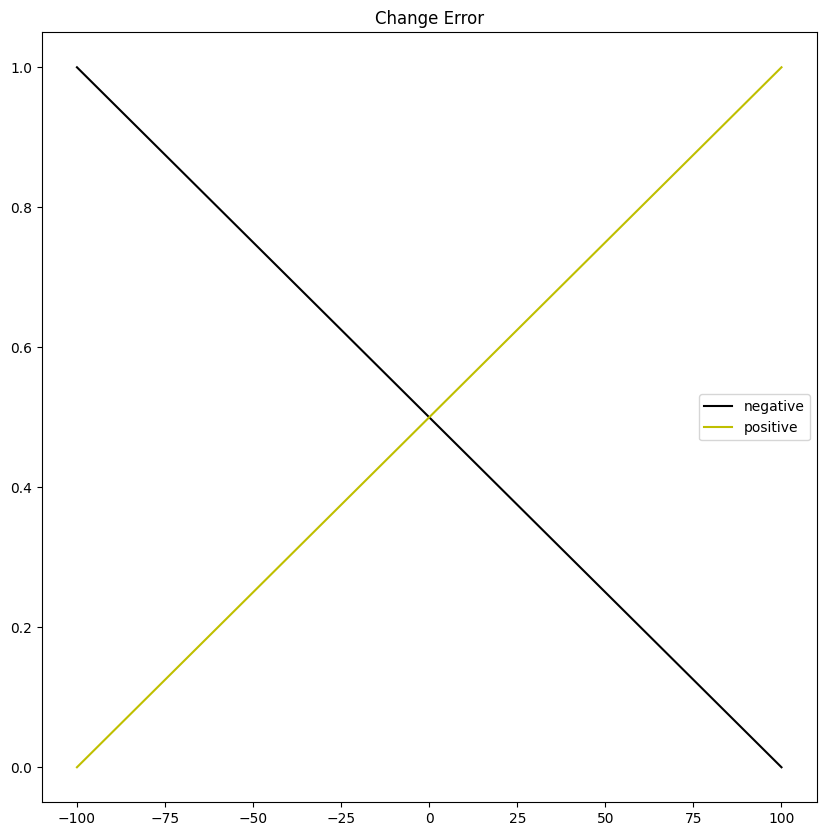

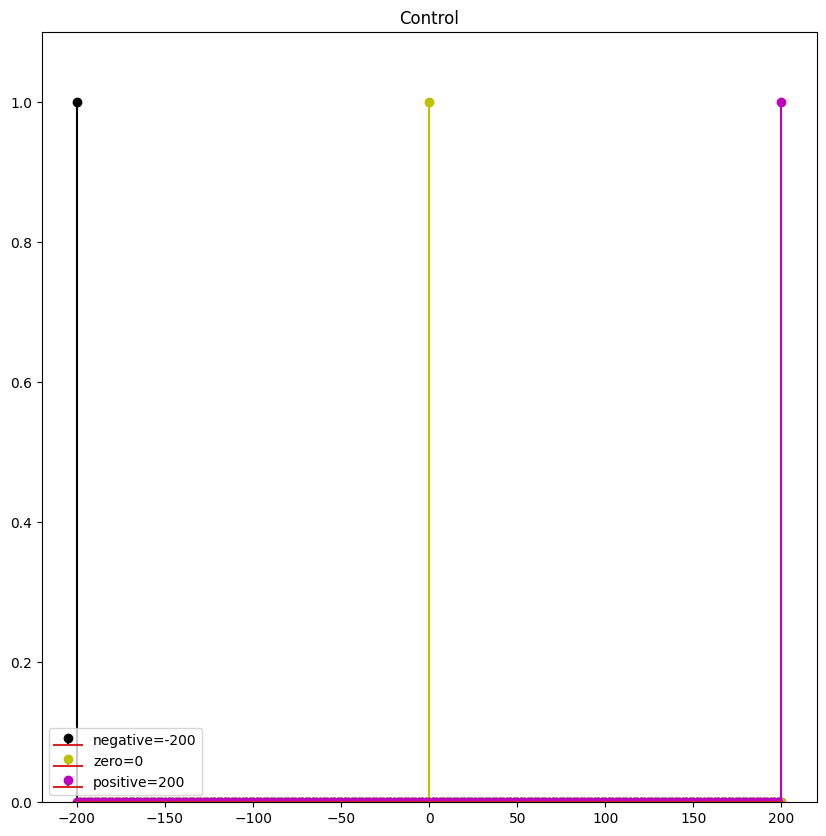

Elapsed time is 1.035874 seconds.


In [20]:
t.tic()
Error_universe = fuzzy_universe('Error', np.arange(-100,101,1), 'continuous')
Error_universe.add_fuzzyset('negative','trimf',[-200,-100,100])
Error_universe.add_fuzzyset('positive','trimf',[-100,100,200])
Error_universe.view_fuzzy()

ChError_universe = fuzzy_universe('Change Error', np.arange(-100,101,1), 'continuous')
ChError_universe.add_fuzzyset('negative','trimf',[-200,-100,100])
ChError_universe.add_fuzzyset('positive','trimf',[-100,100,200])
ChError_universe.view_fuzzy()

Control_universe = fuzzy_universe('Control', np.arange(-200,202,2), 'continuous')
Control_universe.add_fuzzyset('negative','eq','-200')
Control_universe.add_fuzzyset('zero','eq','0')
Control_universe.add_fuzzyset('positive','eq','200')
Control_universe.view_fuzzy()

Linear = inference_system('Linear')
Linear.add_premise(Error_universe)
Linear.add_premise(ChError_universe)
Linear.add_consequence(Control_universe)

Linear.add_rule([['Error','negative'],['Change Error','negative']],['and'],[['Control','negative']])
Linear.add_rule([['Error','negative'],['Change Error','positive']],['and'],[['Control','zero']])
Linear.add_rule([['Error','positive'],['Change Error','negative']],['and'],[['Control','zero']])
Linear.add_rule([['Error','positive'],['Change Error','positive']],['and'],[['Control','positive']])

Linear.configure('Linear')

Linear.build()

t.toc()
del Error_universe
del ChError_universe
del Control_universe


(13, 13)
(13, 13)
(13, 13)


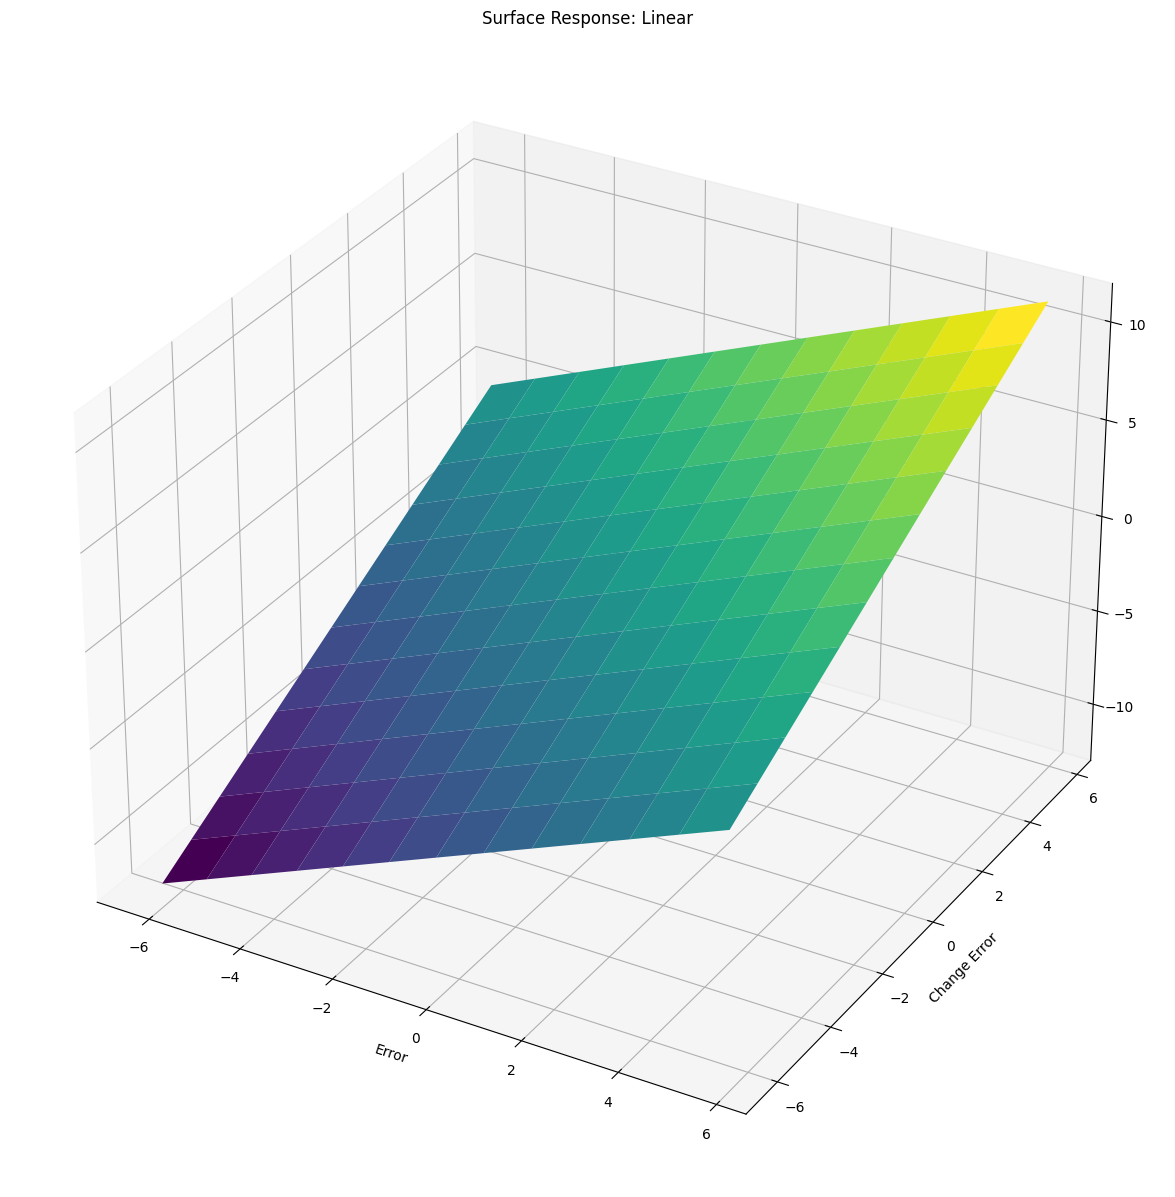

Elapsed time is 0.402877 seconds.


In [21]:
t.tic()
error_values = np.arange(-6.28,6.29,1)
Cherror_values = np.arange(-6.28,6.29,1)
Linear.surface_fuzzy_system([error_values, Cherror_values])
t.toc()

## Defining Proportional Derivative Gains and the Fuzzy Controller

In [22]:
t.tic()
PidFuzzController = fuzzy_controller(Linear,typec='PD-I',tf=TF,DT = T[1], GE=15.92356688, GU=0.0942, GCE=0.636618283, GIE=7.237984945)
PidFuzzController.build()
PidFuzzControllerBlock = PidFuzzController.get_controller()
PidFuzzSystemBlock = PidFuzzController.get_system()
t.toc()

Elapsed time is 0.004244 seconds.


In [23]:
t.tic()
T, Theta = control.input_output_response(PidFuzzSystemBlock,T,Input,0)
t.toc()

Elapsed time is 7.502348 seconds.


Step Info Obtained: 
maxval:  0.7853981633974302 
minval:  0.0 
start_val:  0.0 
end_val:  0.7853981633974302 
timerising:  0.2688458972648432 
overshoot:  0.0 
time overshoot:  N/A 
settlingtime:  0.3128752501667778


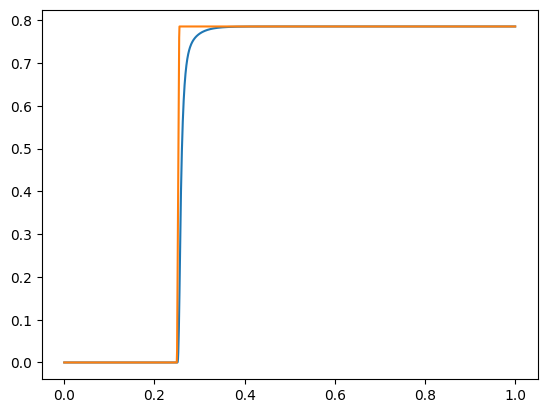

In [24]:
step_info(Theta,T)
plt.plot(T,Theta)
plt.plot(T,Input)


## Showing Block Diagram

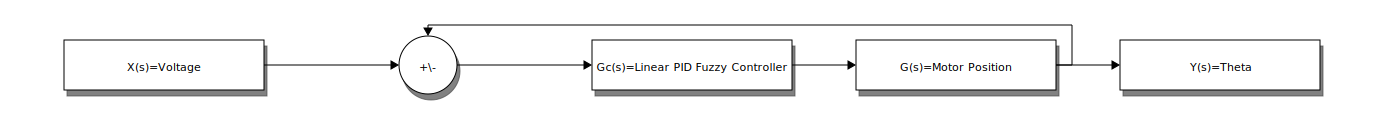

In [25]:
block = "node_width = 200;"
block += "node_height = 50;"
block += "Input [label = \"X(s)=Voltage\"];"
block += "Error [shape = \"circle\", label = \"+\\-\"];"
block += "Gc [label = \"Gc(s)=Linear PID Fuzzy Controller\"];"
block += "Gs [label = \"G(s)=Motor Position\"];"
block += "Output [label = \"Y(s)=Theta\"];  "
block += ' Input -> '
block += ' Error -> '
block += ' Gc -> '
block += ' Gs -> Error '
block += ' Gs -> Output ;'
send_dataBlock(block)
display(SVG('block_diagram.svg'))

## 3D Simulation  of the Motor

In [26]:
settings.allow_interaction = False
settings.default_backend = 'qt'
global prev_rot, vp, val, val2

vp = Plotter(axes=4,interactive=False)
textv = "Linear PID fuzzy controller for position in DC motor\nDr. Martín Montes Rivera"

world = Box([0,0,0], 0.15, 0.15, 0.15).wireframe()
BaseMotor = Cylinder(pos = vector(0,0,0),r=0.05,height=0.05, c="g")
Rotor = Cylinder(pos = vector(0,0,0.035),r=0.003,height=0.02, c="r")
Bar1 = Box(pos = vector(0,0,0.045),length=0.08,width=0.003,height=0.003, c="c")
Thetaval = Latex(r'\theta = ',s=0.03,c="darkblue",bg='',alpha=1,usetex=False).pos(-0.025,0.042,0.03)
val =Text3D('0.00°',s=0.006,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(0.0,0.048,0.03)
val2 =Text3D('t = '+str(np.round(te/ns,2))+'s',s=0.006,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(-0.02,0.058,0.03)
vp+=world
vp+=BaseMotor
vp+=Rotor
vp+=Bar1
vp+=Thetaval
vp+=val
vp+=val2
vp+=textv

vp.show().interactive()

prev_rot = 0.0

pb = ProgressBar(0, ns, 10, c="b")

for tt in pb.range():
    t = int(tt)
    current_rot = np.degrees(Theta[t])
    vp.remove(val)
    vp.remove(val2)
    val =Text3D(str(np.round(current_rot,2))+'°',s=0.006,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(0.0,0.048,0.03)
    val2 =Text3D('t = '+str(np.round(te*t/ns+0.01,2))+'s',s=0.006,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(-0.02,0.058,0.03)
    vp+=val
    vp+=val2
    Bar1.rotate_z(-prev_rot)
    Bar1.rotate_z(current_rot)
    prev_rot = current_rot
    pb.print()
    vp.show()
    time.sleep(0.1)
vp.interactive().close()

settings.allow_interaction = True

vp = Plotter(axes=0, interactive=1)
def slider1(widget, event):
    global prev_rot, vp, val, val2
    vp.remove(val)
    vp.remove(val2)
    t = int(np.floor(widget.GetRepresentation().GetValue()))
    current_rot = np.degrees(Theta[t])
    val =Text3D(str(np.round(current_rot,2))+'°',s=0.006,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(0.0,0.048,0.03)
    val2 =Text3D('t = '+str(np.round(t*te/ns+0.01,2))+'s',s=0.006,c="darkblue",alpha =0.9, italic = True ,depth = 0.01).pos(-0.02,0.058,0.03)
    vp += val
    vp += val2
    Bar1.rotate_z(-prev_rot)
    Bar1.rotate_z(current_rot)
    prev_rot = current_rot

vp+=[world,BaseMotor,Rotor,Bar1,Thetaval,val,val2,textv]
vp.add_slider(slider1, 0, ns-1, value=ns-1,
               pos="bottom-right", title="Sample", c ="blue") 

ViewInteractiveWidget(vp.window)


 ━━━━━━━━━━━━━━━━━━━━━━                               elapsed: 21s (71.1 it/s)            


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)